In [1]:
"""

PROD ALERT 2 CODE

Copyright © 2023 Dr Keith S Reid Cailleach Computing Ltd

keithreid@nhs.net

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated 
documentation files (the “Software”), to deal in the Software without restriction, including without limitation 
the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and 
to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions 
of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED 
TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL 
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER 
DEALINGS IN THE SOFTWARE.

"""

"""

From PROD-ALERT "1"
Institutions were categorised. “Small” were the continuous series of smallest institutions with “null” reports 
commensurate with size and having other monthly reports around 5 and 10. “Complete” institutions were bigger 
than “small” with one or less nulls. To interpolate single nulls among complete reporters, the last observation 
was carried forward, else next carried back (for month 1), both within the 12 months. Other institutions were 
neither small nor complete, and sub-categorised as “Partial”, “Joiner”, or “Null”.

By definition, “Joiners” consistently reported null then consistently reported restrained people – reporting none
then many. “Partial” reporter institutions had intermittent null but were not small enough to be in the 
continuous “small” series - reporting many people restrained then none then many, etc. “Null” report institutions
reported only null all year despite not being small – reporting none throughout while being the size of trusts 
reporting many. Small reporters with null restraints, and “joiner” or “partial” Bed-Day reporting style were 
categorised “null” – if bed counts were partial we did not trust restraint counts.
"""
;

''

In [2]:
# libraries

import numpy  as np
import pandas as pd

In [3]:
# config
                                
pd.options.display.max_rows     = None
pd.options.display.max_columns  = None

"""
We are specificaly naming files in development but will glob them later
"""

def get_beds_files():
    beds_files = ["beds01_Sep_2021.csv", "beds02_Oct_2021.csv", "beds03_Nov_2021.csv",
                  "beds04_Dec_2021.csv", "beds05_Jan_2022.csv", "beds06_Feb_2022.csv",
                  "beds07_Mar_2022.csv", "beds08_Apr_2022.csv", "beds09_May_2022.csv",
                  "beds10_Jun_2022.csv", "beds11_Jul_2022.csv", "beds12_Aug_2022.csv"]
    return beds_files

def get_rstr_files():
    rstr_files = ["rstr01_Sep_2021.csv", "rstr02_Oct_2021.csv", "rstr03_Nov_2021.csv",
                  "rstr04_Dec_2021.csv", "rstr05_Jan_2022.csv", "rstr06_Feb_2022.csv",
                  "rstr07_Mar_2022.csv", "rstr08_Apr_2022.csv", "rstr09_May_2022.csv",
                  "rstr10_Jun_2022.csv", "rstr11_Jul_2022.csv", "rstr12_Aug_2022.csv"]
    return rstr_files

def get_sect_files():
    rstr_files = ["sect01_Sep_2021.csv", "sect02_Oct_2021.csv", "sect03_Nov_2021.csv",
                  "sect04_Dec_2021.csv", "sect05_Jan_2022.csv", "sect06_Feb_2022.csv",
                  "sect07_Mar_2022.csv", "sect08_Apr_2022.csv", "sect09_May_2022.csv",
                  "sect10_Jun_2022.csv", "sect11_Jul_2022.csv", "sect12_Aug_2022.csv"]
    return rstr_files

def get_verbose():
    verbose = "No" # "Yes" or "No"
    return verbose

In [4]:
# get data

def get_providers():
    beds_files              = get_beds_files()
    names_with_some_beds    = []
    for this_file in beds_files:
        df          = pd.read_csv(this_file, header=None) # columns=["Month","Provider","Metric","Count"]
        df.columns  = ["Month","Provider","Metric","Count"]
        for index, row in df.iterrows():
            if row["Count"] != "*":
                names_with_some_beds.append(row["Provider"])
    providers   = sorted(list(set(names_with_some_beds)))
    return providers

In [5]:
# build tables

def build_monthly_providers_beds(providers):
    beds_files              = get_beds_files()
    months                  = [x[4:10] for x in beds_files]
    monthly_providers_beds  = pd.DataFrame(columns = months, index = providers)
    for this_file in beds_files:
        month                       = this_file[4:10]
        monthly_bed_info            = pd.read_csv(this_file, header=None)
        monthly_bed_info.columns    = ["Month","Provider","Metric","Count"]
        for index, row in monthly_bed_info.iterrows():
            if row["Provider"] in providers:
                monthly_providers_beds.at[row["Provider"], month] = row["Count"]
                
    monthly_providers_beds.replace("*",   "0", inplace=True)
    monthly_providers_beds.fillna("0", inplace=True)
    return monthly_providers_beds

def build_monthly_providers_rstr(providers):
    rstr_files              = get_rstr_files()
    months                  = [x[4:10] for x in rstr_files]
    monthly_providers_rstr  = pd.DataFrame(columns = months, index = providers)
    for this_file in rstr_files:
        month                       = this_file[4:10]
        monthly_rstr_info            = pd.read_csv(this_file, header=None)
        monthly_rstr_info.columns    = ["Month","Provider","Metric","Count"]
        for index, row in monthly_rstr_info.iterrows():
            if row["Provider"] in providers:
                monthly_providers_rstr.at[row["Provider"], month] = row["Count"]
    monthly_providers_rstr.replace("*",   "0", inplace=True)
    monthly_providers_rstr.fillna("0", inplace=True)
    return monthly_providers_rstr

def build_monthly_providers_sect(providers):
    sect_files              = get_sect_files()
    months                  = [x[4:10] for x in sect_files]
    monthly_providers_sect  = pd.DataFrame(columns = months, index = providers)
    for this_file in sect_files:
        month                       = this_file[4:10]
        monthly_sect_info            = pd.read_csv(this_file, header=None)
        monthly_sect_info.columns    = ["Month","Provider","Metric","Count"]
        for index, row in monthly_sect_info.iterrows():
            if row["Provider"] in providers:
                monthly_providers_sect.at[row["Provider"], month] = row["Count"]
    monthly_providers_sect.replace("*",   "0", inplace=True)
    monthly_providers_sect.fillna("0", inplace=True)
    return monthly_providers_sect  

In [6]:
# maths model

def order_providers_by_size(monthly_providers_beds):
        # returns NaN for all 0 but none should have that
        # no test - fell out of writing a higher function
        providers_by_size               = monthly_providers_beds.copy()
        providers_by_size               = providers_by_size.astype(int)
        providers_by_size["ProperMean"] = providers_by_size.mask(providers_by_size==0).mean(axis=1)
        providers_by_size               = providers_by_size.sort_values(by="ProperMean")
        providers_by_size               = providers_by_size.sort_values(by="ProperMean")
        providers_by_size.drop(["01_Sep","02_Oct","03_Nov",
                                "04_Dec","05_Jan","06_Feb",
                                "07_Mar","08_Apr","09_May",
                                "10_Jun","11_Jul","12_Aug",
                                "ProperMean"], axis=1, inplace=True)
        return providers_by_size

    

In [7]:
def laplace_correction_and_log(main_table):
    main_table  = main_table.astype(int)
    log_main    = main_table.transform(lambda x: np.log2(x+1))
    return log_main

In [8]:
# view

def greet():
    print("""Welcome to PROD ALERT 2.
             These results are not official do not read them.
             They have not yet been peer reviewed.
             This work is in development.
             The point is that the development will have been done openly, in retrospect, later.
             The underlying figures are already available at NHS Digital.""")
    
def maybe_tell_providers(providers_by_size):
    verbose = get_verbose()
    if verbose == "Yes":
        print("\nThese providers had some beds here they are in size of reported beds:\n")
        display(providers_by_size)


def maybe_tell_main_table(main_table):
    verbose = get_verbose()
    if verbose == "Yes":
        print("\nHere are reported bed-days, sectioned people and restrained people by month with providers ordered by size:\n")
        display(providers_by_size)
        
        
def maybe_tell_monthly_providers_beds(monthly_providers_beds):
    verbose = get_verbose()
    if verbose == "Yes":
        print("""\nHere is a table of monthly providers and beds
                   * and empty are replaced with 0:\n""")
        display(monthly_providers_beds)
        
def maybe_tell_monthly_providers_rstr(monthly_providers_rstr):
    verbose = get_verbose()
    if verbose == "Yes":
        print("""\nHere is a table of monthly providers and reported people restrained per month
                   * and empty are replaced with 0:\n""")
        display(monthly_providers_rstr)
        
def maybe_tell_monthly_providers_sect(monthly_providers_sect):
    verbose = get_verbose()
    if verbose == "Yes":
        print("""\nHere is a table of monthly providers and reported people detained per month
                   * and empty are replaced with 0:\n""")
        display(monthly_providers_sect)

Welcome to PROD ALERT 2.
             These results are not official do not read them.
             They have not yet been peer reviewed.
             This work is in development.
             The point is that the development will have been done openly, in retrospect, later.
             The underlying figures are already available at NHS Digital.


,01_Sep,02_Oct,03_Nov,04_Dec,05_Jan,06_Feb,07_Mar,08_Apr,09_May,10_Jun,11_Jul,12_Aug,01_Sep,02_Oct,03_Nov,04_Dec,05_Jan,06_Feb,07_Mar,08_Apr,09_May,10_Jun,11_Jul,12_Aug,01_Sep,02_Oct,03_Nov,04_Dec,05_Jan,06_Feb,07_Mar,08_Apr,09_May,10_Jun,11_Jul,12_Aug
SCHOEN CLINIC YORK,0.000000,8.611025,0.000000,0.000000,0.000000,0.000000,5.807355,7.330917,7.539159,7.139551,6.584963,6.977280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GREAT ORMOND STREET HOSPITAL FOR CHILDREN NHS FOUNDATION TRUST,7.577429,7.614710,7.614710,7.754888,7.754888,7.614710,7.651052,7.330917,7.285402,7.499846,7.539159,7.539159,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ALDER HEY CHILDREN'S NHS FOUNDATION TRUST,7.754888,7.459432,7.087463,7.087463,7.787903,7.971544,8.134426,7.912889,8.082149,7.912889,7.754888,7.942515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TURNING POINT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.939579,7.189825,7.189825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NEWMARKET HOUSE HEALTHCARE LTD,8.082149,8.257388,8.209453,8.159871,8.134426,7.942515,8.257388,8.233620,8.159871,8.233620,8.257388,8.257388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
WHITTINGTON HEALTH NHS TRUST,7.577429,8.134426,8.326429,8.326429,8.434628,8.303781,8.257388,8.257388,8.280771,8.280771,8.348728,8.257388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MANCHESTER UNIVERSITY NHS FOUNDATION TRUST,8.027906,7.971544,8.348728,0.000000,0.000000,8.257388,8.455327,8.209453,8.184875,8.082149,8.348728,8.475733,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NORTHUMBRIA HEALTHCARE NHS FOUNDATION TRUST,6.918863,6.977280,6.918863,8.082149,7.912889,8.000000,8.326429,8.665336,8.968667,8.968667,9.194757,9.157347,0.000000,0.000000,0.000000,2.584963,3.459432,3.459432,3.459432,2.584963,4.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NEWBRIDGE CARE SYSTEMS LTD,8.515700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BRAMLEY HEALTH,8.717676,0.000000,8.734710,8.864186,8.592457,8.370687,8.413628,8.370687,8.413628,8.370687,8.413628,8.413628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:>

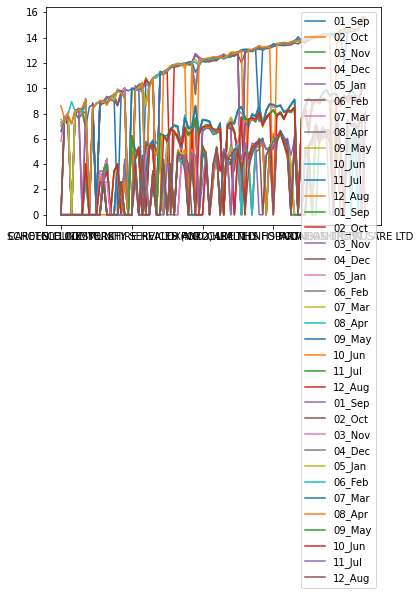

In [9]:
# control

if __name__=="__main__":
                
    greet()
                            
    providers               = get_providers()
    # exclude childrens hospitals with no detentions
    
    monthly_providers_beds  = build_monthly_providers_beds(providers)
    monthly_providers_rstr  = build_monthly_providers_rstr(providers)
    monthly_providers_sect  = build_monthly_providers_sect(providers)
    ordered_providers       = order_providers_by_size(monthly_providers_beds)
    
    beds = pd.concat([ordered_providers,monthly_providers_beds], axis=1).reindex(ordered_providers.index)
    sect = pd.concat([beds,monthly_providers_sect], axis=1).reindex(beds.index)
    rstr = pd.concat([sect,monthly_providers_rstr], axis=1).reindex(sect.index)
                
    main_table  = rstr.copy()
    log_main    = laplace_correction_and_log(main_table)
    
    maybe_tell_providers(ordered_providers)
    maybe_tell_monthly_providers_beds(monthly_providers_beds)
    maybe_tell_monthly_providers_rstr(monthly_providers_rstr)
    maybe_tell_monthly_providers_sect(monthly_providers_sect)
    maybe_tell_main_table(main_table)
    
    display(log_main)
    graph = log_main.plot()
    display(graph)
    
    
    
    

In [10]:
# tests

def test_build_monthly_providers_beds():
    providers              = get_providers()
    monthly_providers_beds = build_monthly_providers_beds(providers)
    assert type(monthly_providers_beds)    == pd.DataFrame, "type test"
    assert type(monthly_providers_beds["01_Sep"]) == pd.Series, "type test"
    assert monthly_providers_beds.at["WEST LONDON NHS TRUST","01_Sep"] == "19235", "correct value and type"
    assert monthly_providers_beds.at["WEST LONDON NHS TRUST","01_Sep"] != 19235,   "correct value and type"
    assert monthly_providers_beds.at["WEST LONDON NHS TRUST","01_Sep"] != "999",   "correct value and type"
    assert len(monthly_providers_beds)     == len(set(providers)), "uniqueness test"
    assert monthly_providers_beds.index[1] == providers[1], "matches providers test"
    print("passed build monthly providers beds")
    
def test_build_monthly_providers_rstr():
    providers              = get_providers()
    monthly_providers_rstr = build_monthly_providers_rstr(providers)
    assert type(monthly_providers_rstr)    == pd.DataFrame, "type test"
    assert type(monthly_providers_rstr["01_Sep"]) == pd.Series, "type test"
    assert monthly_providers_rstr.at["WEST LONDON NHS TRUST","01_Sep"] == "75", "correct value and type"
    assert monthly_providers_rstr.at["WEST LONDON NHS TRUST","01_Sep"] != 75,   "correct value and type"
    assert monthly_providers_rstr.at["WEST LONDON NHS TRUST","01_Sep"] != "999","correct value and type"  
    assert len(monthly_providers_rstr)     == len(set(providers)), "uniqueness test"
    assert monthly_providers_rstr.index[1] == providers[1], "matches providers test"
    print("passed build monthly providers rstr")
    
def test_build_monthly_providers_sect():
    providers              = get_providers()
    monthly_providers_sect = build_monthly_providers_sect(providers)
    assert type(monthly_providers_sect)    == pd.DataFrame, "type test"
    assert type(monthly_providers_sect["01_Sep"]) == pd.Series, "type test"
    assert monthly_providers_sect.at["WEST LONDON NHS TRUST","01_Sep"] == "565", "correct value and type"
    assert monthly_providers_sect.at["WEST LONDON NHS TRUST","01_Sep"] != 565,   "correct value and type"
    assert monthly_providers_sect.at["WEST LONDON NHS TRUST","01_Sep"] != "999","correct value and type"  
    assert len(monthly_providers_sect)     == len(set(providers)), "uniqueness test"
    assert monthly_providers_sect.index[1] == providers[1], "matches providers test"
    print("passed build monthly providers sect")
    
def test_get_providers():
    providers = get_providers()
    assert type(providers)    == list, "type test"
    assert type(providers[1]) == str, "type test"
    assert len(providers)  == len(set(providers)), "uniqueness test"
    print("passed get providers")
    
def test_laplace_correction_and_log():
    toy         = {'Number':[4,3,2,1]}
    toy_df      = pd.DataFrame(toy)
    log_main    = laplace_correction_and_log(toy_df)
    assert list(log_main.Number) == [2.321928094887362, 2.0, 1.584962500721156, 1.0]    
    toy         = {'Jam':[4,3,2,1],'Spam':[15,31,63,0]}
    toy_df      = pd.DataFrame(toy)
    log_main    = laplace_correction_and_log(toy_df)
    assert list(log_main.Jam)  == [2.321928094887362, 2.0, 1.584962500721156, 1.0]
    assert list(log_main.Spam) == [4.0, 5.0, 6.0, 0.0]
    print("passed laplace correction and log")

def all_tests():
    test_build_monthly_providers_beds()
    test_build_monthly_providers_rstr()
    test_build_monthly_providers_sect()  
    test_get_providers()
    test_laplace_correction_and_log()
    print("passed all tests")
    
all_tests()    

passed build monthly providers beds
passed build monthly providers rstr
passed build monthly providers sect
passed get providers
passed laplace correction and log
passed all tests


In [11]:
# scraps

#
#def allocate_providers(providers_by_size):
    
    # how small is small
    #     it is small enough to be
    #         in the continuous series of smallest institutions
    #         with “null” reports commensurate with size for sect and rstr
    #         having other monthly reports around 5 and 10
    
    # start at smallest work up by size through sect and rstr checking continuity
    #     and that other values are 5 or 10
    
    # are you big or small
    #     if you are small we believe your zeros and use them in the average
    #     if you are big we do not believe your zeros and we only average your big figures
    
    # if you are big and have n>=11 months of the year count>0 you are a complete reporter
    #     we replace your only 0 with the last value
    
    # if you are big and have on-off reporting you are partial and we do the estimate based
    #     we only average your big figures
    
    # if you are big and join in reporting
    #     we only average your later consecutive non-zero reports
    
#    allocation = {"foo":"bar"}
#    return allocation

#def test_allocate_providers():
#    providers               = get_providers()
#    monthly_providers_beds  = build_monthly_providers_beds(providers)
#    allocation              = allocate_providers(monthly_providers_beds)
#    assert type(allocation) == dict, "type check"
#    
#test_allocate_providers()
